# CNN classifier

https://cs230.stanford.edu/lecture/

In [1]:
!pip install torch
!pip install torchvision
!pip install scikit-learn
!pip install tensorboard
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install seaborn 
!pip list


Package                      Version
---------------------------- -----------
absl-py                      1.2.0
altair                       4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.2
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        21.4.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
blinker                      1.5
cachetools                   5.2.0
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
click                        8.1.3
colorama                     0.4.5
commonmark                   0.9.1
contourpy                    1.0.5
cycler                       0.11.0
DateTime                     4.7
debugpy                      1.6.2
decorator                    5.1.1
defusedxml                   0.7.1
emoji                        2.1.0
entry

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import time
import copy
from sklearn.metrics import confusion_matrix

import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns

from tensorflow.keras.models import load_model

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
#BATCH_SIZE = 256 if AVAIL_GPUS else 64
BATCH_SIZE = 32
NUM_WORKERS = int(os.cpu_count() / 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else None)
print(BATCH_SIZE)
print(NUM_WORKERS)

None
32
2


In [4]:
class ImageLoader:
    '''
    Args:
    root is the path where are stored the folders.
    phase can be 'train' or 'test', in function if
    you want a training (Augmented) or test (original) dataset.
    batch_size
    num_workers
    '''
    def __init__(self, root_train, root_test, phase, batch_size, num_workers):
        self.phase = phase
        self.root_train = root_train
        self.root_test = root_test
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def apply(self):
        transforms_dict = {
            'augmented': transforms.Compose([transforms.Resize((64,64)),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip()]),
            'origin': transforms.Compose([transforms.Resize((64,64)),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])}

        df_augmented = datasets.ImageFolder(root=self.root_train, transform=transforms_dict['augmented'])
        df_origin = datasets.ImageFolder(root=self.root_train, transform=transforms_dict['origin'])
        df_train, df_val = random_split(df_origin, (round(0.85*len(df_origin)), round(0.15*len(df_origin))))
        
        df = ConcatDataset([df_train, df_augmented])
        print('train', len(df))
        print('val', len(df_val))

        if self.phase == 'train':
    
            train_loader = DataLoader(df, batch_size=self.batch_size,
                                      shuffle=True, num_workers=self.num_workers)
            val_loader = DataLoader(df_val, batch_size=self.batch_size,
                                    shuffle=False, num_workers=self.num_workers)
            return [train_loader, val_loader]
        else:
            df_test = datasets.ImageFolder(root=self.root_test, transform=transforms_dict['origin'])
            print('test', len(df_test))
                                           
            test_loader = DataLoader(df_test, batch_size=self.batch_size,
                                     shuffle=False, num_workers=self.num_workers)
            return test_loader

In [5]:
path_train = 'I:/College/image-classifier/class/test'
path_test = 'I:/College/image-classifier/class/train'
load_train = ImageLoader(root_train=path_train, root_test=path_test , phase='train', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
img_train = load_train.apply()

load_test = ImageLoader(root_train=path_train, root_test=path_test, phase='test', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
img_test = load_test.apply()

train 9470
val 768
train 9470
val 768
test 5119


In [6]:
df = datasets.ImageFolder(root='I:/College/image-classifier/class/test', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                     transforms.Grayscale(num_output_channels=1),
                                                                                                        transforms.ToTensor()]))
df_test = datasets.ImageFolder(root='I:/College/image-classifier/class/train', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                            transforms.Grayscale(num_output_channels=1),
                                                                                                            transforms.ToTensor()]))
                                                                                                            
dataloader = {
    'train': img_train[0],
    'val': img_train[1],
    'test': img_test
}

dataset_size = {
    'train': 2775,
    'val': 255,
    'test': 2985
}                                                                

In [7]:
dataiter = iter(img_train[0])
images, labels = dataiter.next()

In [8]:
def imshow(img, label):
    classes = df.classes
    plt.imshow(img.permute(1, 2, 0))
    plt.title('label:' + str(classes[label]))
    plt.show()

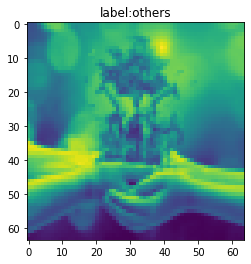

torch.Size([1, 64, 64])

In [9]:
n = int(np.random.randint(0, BATCH_SIZE))
imshow(images[n], labels[n])
images[n].shape

In [10]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(1, 8, 3, stride=1)
        self.conv1_bn = nn.BatchNorm2d(8)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop1 = nn.Dropout(0.5)

        self.cnn2 = nn.Conv2d(8, 16, 3, stride=1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.5)

        self.cnn3 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.drop3 = nn.Dropout(0.2)

        self.fc = nn.Linear(4608, 15)
        self.fc_bn = nn.BatchNorm1d(15)
        self.dropfc = nn.Dropout(0.2)
        

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = self.fc_bn(x)
        
        return x

In [12]:
model = CNN()
model.apply(initialize_weights)
#model.to(device)
#model.state_dict()

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (cnn3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=4608, out_features=15, bias=True)
  (fc_bn): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropfc): Dropout(p=0.2, inplace=False)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=200):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
          
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            writer.add_scalar(f"Loss {phase}", epoch_loss, epoch)
            writer.add_scalar(f"Acc {phase}", epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
Model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=200)
writer.flush()

Epoch 0/199
----------
train Loss: 7.0257 Acc: 2.2627
val Loss: 5.2169 Acc: 2.2588

Epoch 1/199
----------
train Loss: 5.0769 Acc: 2.6263
val Loss: 4.0458 Acc: 2.3529

Epoch 2/199
----------
train Loss: 3.9232 Acc: 2.6804
val Loss: 3.7151 Acc: 2.2275

Epoch 3/199
----------
train Loss: 3.1564 Acc: 2.7348
val Loss: 2.4723 Acc: 2.4235

Epoch 4/199
----------
train Loss: 2.6443 Acc: 2.7733
val Loss: 2.1816 Acc: 2.4510

Epoch 5/199
----------
train Loss: 2.3033 Acc: 2.8025
val Loss: 2.1804 Acc: 2.4000

Epoch 6/199
----------
train Loss: 1.9902 Acc: 2.8533
val Loss: 1.7776 Acc: 2.4980

Epoch 7/199
----------
train Loss: 1.7583 Acc: 2.9121
val Loss: 1.7455 Acc: 2.4863

Epoch 8/199
----------
train Loss: 1.7056 Acc: 2.9160
val Loss: 1.7117 Acc: 2.4902

Epoch 9/199
----------
train Loss: 1.6852 Acc: 2.9409
val Loss: 1.6942 Acc: 2.4941

Epoch 10/199
----------
train Loss: 1.6703 Acc: 2.9276
val Loss: 1.6698 Acc: 2.4784

Epoch 11/199
----------
train Loss: 1.6393 Acc: 2.9492
val Loss: 1.6099 Acc

val Loss: 1.5804 Acc: 2.5137

Epoch 97/199
----------
train Loss: 1.4796 Acc: 2.9834
val Loss: 1.5903 Acc: 2.5098

Epoch 98/199
----------
train Loss: 1.5258 Acc: 2.9445
val Loss: 1.5937 Acc: 2.5020

Epoch 99/199
----------
train Loss: 1.5155 Acc: 2.9661
val Loss: 1.5866 Acc: 2.5176

Epoch 100/199
----------
train Loss: 1.5148 Acc: 2.9686
val Loss: 1.5935 Acc: 2.5098

Epoch 101/199
----------
train Loss: 1.5120 Acc: 2.9614
val Loss: 1.5709 Acc: 2.5137

Epoch 102/199
----------
train Loss: 1.5087 Acc: 2.9679
val Loss: 1.5591 Acc: 2.5059

Epoch 103/199
----------
train Loss: 1.5413 Acc: 2.9625
val Loss: 1.5661 Acc: 2.5098

Epoch 104/199
----------
train Loss: 1.4845 Acc: 2.9802
val Loss: 1.5721 Acc: 2.5020

Epoch 105/199
----------
train Loss: 1.5158 Acc: 2.9676
val Loss: 1.5720 Acc: 2.5216

Epoch 106/199
----------
train Loss: 1.5152 Acc: 2.9759
val Loss: 1.5690 Acc: 2.5098

Epoch 107/199
----------
train Loss: 1.5368 Acc: 2.9625
val Loss: 1.5632 Acc: 2.5216

Epoch 108/199
----------
tr

train Loss: 1.5058 Acc: 2.9705
val Loss: 1.5722 Acc: 2.5294

Epoch 193/199
----------
train Loss: 1.5435 Acc: 2.9402
val Loss: 1.6272 Acc: 2.5059

Epoch 194/199
----------
train Loss: 1.5362 Acc: 2.9643
val Loss: 1.5743 Acc: 2.5098

Epoch 195/199
----------
train Loss: 1.5320 Acc: 2.9557
val Loss: 1.5641 Acc: 2.5176

Epoch 196/199
----------
train Loss: 1.5279 Acc: 2.9618
val Loss: 1.5775 Acc: 2.5137

Epoch 197/199
----------
train Loss: 1.5268 Acc: 2.9686
val Loss: 1.5640 Acc: 2.5333

Epoch 198/199
----------
train Loss: 1.5343 Acc: 2.9535
val Loss: 1.5534 Acc: 2.5059

Epoch 199/199
----------
train Loss: 1.5359 Acc: 2.9643
val Loss: 1.5672 Acc: 2.5098

Training complete in 1113m 0s
Best val Acc: 2.537255


In [17]:
torch.save(Model.state_dict(), 'I:/College/Classifier/augumented/model_dict_augmented.pt')

In [18]:
# writer.close()
# import tensorboard
# %load_ext tensorboard
# !kill 6204
# %reload_ext tensorboard
# %tensorboard --logdir=runs

writer.close()
import tensorboard
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 4328), started 2 days, 17:06:52 ago. (Use '!kill 4328' to kill it.)

In [19]:
# @torch.no_grad()
def get_predict(model, loader):
    predict_tensor = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        predict = model(images)
        # _, preds = torch.max(predict, 1)
        
        predict_tensor = torch.cat(
            (predict_tensor, predict),
            dim=0)

    return predict_tensor

In [20]:
with torch.no_grad():
    test_predict = get_predict(Model, img_test)
    
test_predict.shape

torch.Size([5119, 15])

In [21]:
print(test_predict.requires_grad)
print(test_predict.grad)
print(test_predict.grad_fn)

False
None
None


In [22]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

predict_correct = get_num_correct(test_predict, torch.tensor(df_test.targets))

print(predict_correct)
print(predict_correct/len(df_test))

4651
0.908575893729244


In [23]:
stacked = torch.stack(
    (torch.tensor(df_test.targets),
    #test_predict.int()),
    test_predict.argmax(dim=1)),
    dim=1
)
stacked.shape

torch.Size([5119, 2])

In [24]:
cmt = torch.zeros(15,15, dtype=torch.int32)
for p in stacked:
    i,j = p.tolist()
    cmt[i,j] = cmt[i,j] + 1

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2875  204]
 [ 264 1776]]


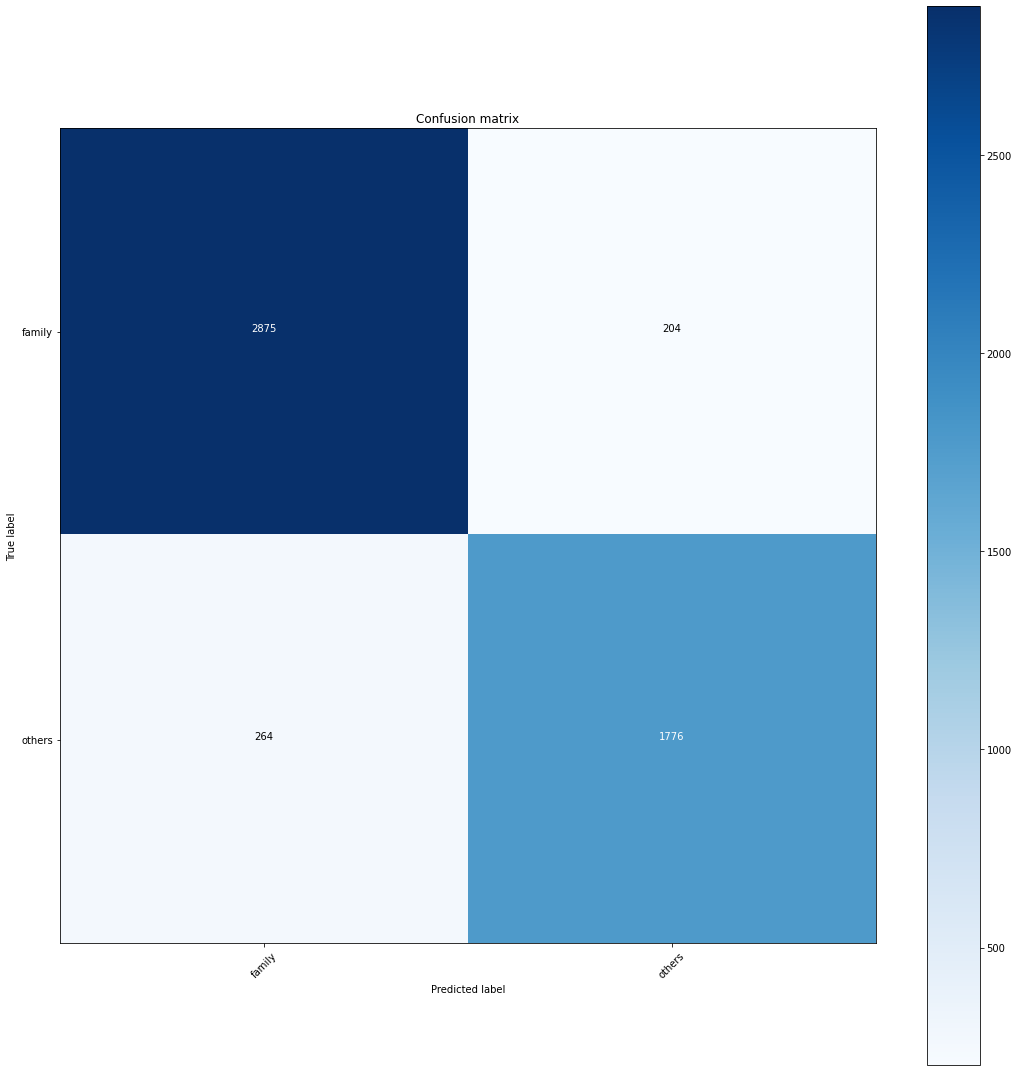

In [26]:
cm = confusion_matrix(torch.tensor(df_test.targets), test_predict.argmax(dim=1))

names = df_test.classes
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, names)

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
#     plt.imshow(cv2.cvtColor(inp, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=10):
    model.load_state_dict(torch.load("I:/College/Classifier/augumented/model_dict_augmented.pt"))
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {df.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

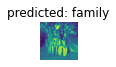

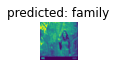

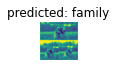

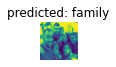

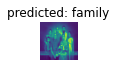

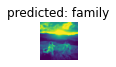

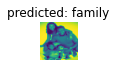

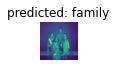

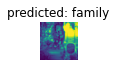

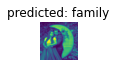

In [28]:
visualize_model(Model)